# Approximate Bayesian Computation with Model Discrepancy

## tl;dr
> In this notebook we demonstrate how to apply Approximate Bayesian Computation to infer posterior
> parameter distribution of a model of the fast sodium ion channel current by using a stochastic distance kernel and
> assuming variance due to measurement uncertainty and model discrepancy around experimental data points.

We assume that our ion channel model of the sodium channel, denoted $f$, can be simulated with a set of parameters ($\theta$) to produce some output of current exiting or entering a cell over time. This current may be processed into summary statistics as in conventional voltage clamp experiments, such as peak current observed or time constants of rise/decay rates.

$$
\mathbf{z} = S(f(\theta))
$$

where $\mathbf{z}$ is the final model output and $S$ is a function converting raw model output to summary statistics.

---

In Bayesian methods, we wish to infer the posterior distribution for our model parameters, $\mathbf{\theta}$, given the experimental data we have observed, $\mathbf{y}$. We can write this as:

$$
\pi(\mathbf{\theta}|\mathbf{y}) \propto \pi(\mathbf{y}|\mathbf{\theta})\pi(\mathbf{\theta}),
$$

where $\pi(\mathbf{y}|\mathbf{\theta})$ is called the likelihood function and $\pi(\mathbf{\theta})$ is the prior distribution of parameters, representing any belief we have of their value before observing experimental data.

In complex mathematical models, the likelihood function is usually difficult or impossible to calculate analytically, and numerical approximations are used to obtain an estimate to the posterior distribution $\pi(\mathbf{\theta}|\mathbf{y})$. In cases where multiple forward evaluations of the model are feasible, Approximate Bayesian Computation (ABC) replaces exact calculation of the likelihood function with comparisons to experimental data.

---

In *classic* ABC, we usually approximate the likelihood density by some distance function $\rho(\cdot,\cdot)$ and accept or reject a sample from $\pi(\mathbf{\theta})$ using the forward evaluation of the model under those parameters and some tolerance $\epsilon$. In this case, the likelihood becomes:

$$
\hat{\pi}(\mathbf{y}|\mathbf{\theta}) = \mathbb{1}(\rho(\mathbf{y}, \mathbf{z}) < \epsilon)
$$

The posterior approximation in this case becomes $\pi(\theta | \rho(\mathbf{y}|\cdot)<\epsilon)$ which is generally set up so as to tend to the true posterior.

[Wilkinson](https://doi.org/10.1515/sagmb-2013-0010) recognised that, in certain cases, ABC is equivalent to exact inference under model uncertainty. If $\rho(\cdot,\cdot)$ is Euclidean distance, the above acceptor is the same as assuming uniform error around each experimental data point.

The estimate of the likelihood can thus be generalised to a distribution other than the uniform distribution traditionally used in acceptance:
 
$$
\hat{\pi}(\mathbf{y}|\mathbf{\theta}) = \pi(\mathbf{y}|\mathbf{z}, \epsilon)
$$

where $\epsilon$ here represents some variance of the distribution. The 'classic' likelihood is equivalent to using a uniform distribution of width $\epsilon/2$ around each data point. 

A natural choice of generalised likelihood would be a Gaussian distribution centered on each experimental data point with variance equal to the measurement variance of the experimental data. It is also important to consider that the model, even when run at its 'optimum' parameter settings, may still not be equal to experimental data, and so we can also include model discrepancy in this variance.

## Problem description

For this example of ABC under measurement uncertainty and model discrepancy, we will use ABC to calibrate the parameters of two ion channel models of fast inactivation gate of the fast sodium current in human atrial myocytes. Our models are based on one of the first models developed of the human atrial cardiac cell [Nygren et al](https://doi.org/10.1161/01.res.82.1.63).

We calibrate parameters of the fast inactivation gate, denoted $h_1$, of this model to experimental measurements in human atrial myocytes conducted by [Sakakibara et al](https://doi.org/10.1161/01.res.71.3.535), which were used for calibration in the original publication. We will then compare this to a standardised formulation for the $h_1$ gate, with fewer parameters, which was proposed by [Beattie et al](https://doi.org/10.1113/JP275733) for use in a potassium current, and which we have shown recently to also represent the fast sodium current with reasonable accuracy (TODO: reference incoming).

The calibration approach will use the generalised ABC acceptance kernel described above, with Gaussian distributions around each data point with variance equal to measurement uncertainty and assumed model discrepancy. We do not *a prior* know the model discrepancy for each case, so this variance can be inferred alongside the model parameters.

## Prerequisites

The remainder of this notebook assumes the user is comfortable with the concept of ABC and in particular the sequential Monte Carlo (SMC) form. A good overview of ABC is given by [Sunnåker et al](https://doi.org/10.1371/journal.pcbi.1002803), and the SMC algorithm was introduced by [Toni et al](https://doi.org/10.1098/rsif.2008.0172).

It is not strictly necessary to understand ion channel modelling, but an interested reader would benefit from reading Chapter 3 of [Keener and Sneyd](https://link.springer.com/book/10.1007%2F978-0-387-75847-3).

## Setup

We first import standard libraries and functions from *ionchannelABC* that will be used for setup and analysis of our problem.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [27]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import DiscrepancyKernel
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_variables

INFO:myokit:Loading Myokit version 1.28.3


We will use [myokit](http://myokit.org/) to simulate the ion channel models, and [pyabc](https://github.com/icb-dcm/pyabc) implementations of the ABC-SMC algorithms. See the corresponding documentation for each of these libraries for further information on some of the functions used below.

In [3]:
import myokit
import pyabc

We import an ionchannelABC *Experiment* for each dataset. This class encapsulates the reported experimental data and error bars, the experimental voltage-clamp protocol and conditions and the summary statistics function (see the [file](experiments/ina_sakakibara.py) for further details).

We import three experiments relevant to calibration of the fast inactivation gate:
 - Steady-state inactivation
 - Fast inactivation time constant
 - Fast recovery time constant

A more thorough description of experimental protocols for each of these datasets can be found in published data by [Sakakibara et al](https://doi.org/10.1161/01.res.71.3.535).

In [4]:
from experiments.ina_sakakibara import (sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_rec_fast)

We specify the location of the myokit model files for both of the models considered.

Note that we have shifted the steady-state activation and inactivation curves in the Nygren model to remove the $+22.8mV$ offset added in the original model publication (though this could be reverted if desired).

In [6]:
nyg_modelfile = 'models/nygren_ina_shifted.mmt'
sta_modelfile = 'models/standardised_ina_nyg_act.mmt'

We can plot the Nygren model results without altering the parameters using the ```plot_sim_results``` function from the pyabc library.

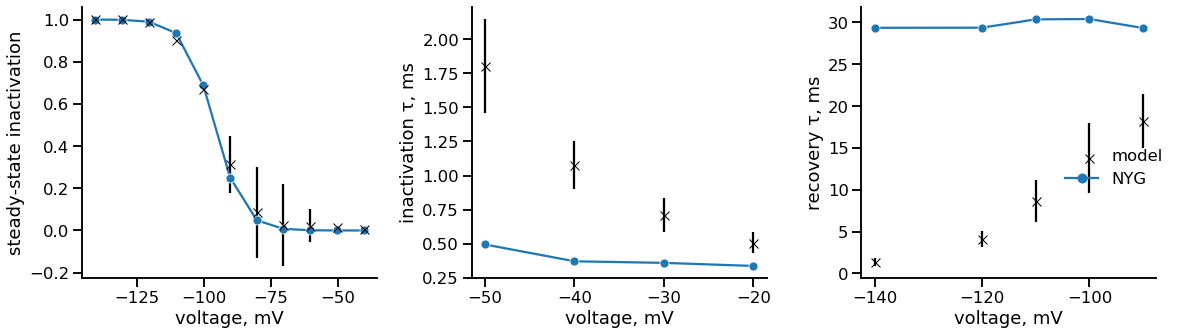

In [13]:
g = plot_sim_results(nyg_modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast)
xlabel = "voltage, mV"
ylabels = ["steady-state inactivation", "inactivation τ, ms", "recovery τ, ms"]

for ax in g.axes[0]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes[0], ylabels):
    ax.set_ylabel(yl)
for ax in g.axes[0].flatten():
    ax.set_title('')
plt.tight_layout()

We observe the Nygren model reproduces the steady-state experiment curve to a better degree than the time constant behaviour with its default parameters.

## Setup for calibration of Nygren model

We need to specify the prior distribution for each parameter in the model. There are six parameters controlling the fast inactivation of the Nygren inactivation gate. We set their prior distributions to uniform distributions with width spanning 50% to 200% of the originally published values.

In [15]:
m = myokit.load_model(nyg_modelfile)

In [61]:
param_keys = ['ina.q1', 'ina.q2', 'ina.q3', 'ina.q4', 'ina.q5', 'ina.q6']
limits_nyg = {key: (0.5*m.get(key).value(), 2*m.get(key).value()) 
              for key in param_keys}
prior_RV = {key: pyabc.RV("uniform", a, b - a)
            for key, (a,b) in limits_nyg.items()}

We also need to specify prior distributions for the additional variance due to model discrepancy. This variance is on the distribution around the difference between the experimental and model output ($\mathbf{y}-\mathbf{z}$) and so we would expect zero mode and non-zero variance *a prior*.

To avoid sampling issues due to high dimensionality, we add a parameter for each experiment. This additional variance will be added to the measurement variance at each data point in the corresponding experiment. We specify uniform distributions between 1e-7 and 0.5 for each.

In [18]:
prior_RV.update({'model_var0': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var1': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var2': pyabc.RV("uniform", 1e-7, 0.5)})
prior = pyabc.Distribution(**prior_RV)

We now call the ```setup``` function for *ionchannelABC* which combines the model and experiments to produce:
- ```observations```: A pandas DataFrame containing normalised experimental data points and measurement uncertainties.
- ```model```: A Callable function which accepts parameters as inputs and outputs the raw current traces corresponding to the protocol in each Experiment.
- ```summary_statistics```: A separate function which converts the raw output of model to the summary statistics corresponding to experimental observations.

In [20]:
observations, model, summary_statistics = setup(nyg_modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast,
                                                err_pars=['model_var0','model_var1','model_var2'])

In [21]:
# Test it all works correctly with set-up functions
assert len(observations)==len(summary_statistics(model({})))
assert len(observations) == len(summary_statistics(model(prior.rvs())))

In [22]:
# We need to store the correct order of the keys for use in the distance kernel
keys = list(observations.index)
keys = [str(k) for k in keys]

In [23]:
print(observations)

           x         y  variance exp_id  normalise_factor
0  -140.6890  1.000000  0.000000      0          1.002420
1  -130.8560  0.999920  0.000000      0          1.002420
2  -120.6080  0.984181  0.000000      0          1.002420
3  -110.4540  0.902179  0.000000      0          1.002420
4  -100.3210  0.667767  0.000000      0          1.002420
5   -90.2885  0.312273  0.017769      0          1.002420
6   -80.3212  0.085694  0.046010      0          1.002420
7   -70.4131  0.025982  0.037505      0          1.002420
8   -60.3302  0.022894  0.006026      0          1.002420
9   -50.3310  0.017397  0.000000      0          1.002420
10  -40.4160  0.005877  0.000000      0          1.002420
11  -50.0000  1.000000  0.036633      1          1.802947
12  -40.0000  0.597207  0.009451      1          1.802947
13  -30.0000  0.395274  0.004883      1          1.802947
14  -20.0000  0.281418  0.001809      1          1.802947
15 -140.0000  0.076312  0.000739      2         18.227096
16 -120.0000  

In [25]:
measure_var = list(observations.variance)
exp_mask = list(observations.exp_id)

```measure_var``` contains the known variance due to measurement uncertainties that was reported in the experimental publication and is assumed fixed in the following calibration (as opposed to the variance due to model discrepancy which is also calibrated on a per-experiment basis.

In [26]:
print(measure_var)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.017768753873820486, 0.04601043797154876, 0.037504879673364994, 0.006025872572887089, 0.0, 0.0, 0.03663293572276556, 0.009451278956944304, 0.004882545476780795, 0.0018090338628526203, 0.0007389862320763683, 0.002894001958802616, 0.019137379416300355, 0.05253887204938633, 0.03063899175601628]


## Setup and run ABC-SMC using pyABC

See [pyABC documentation](https://pyabc.readthedocs.io/en/latest/) for further details.

In [28]:
# path to results database (will be created if doesn't already exist)
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ina_model_discrepancy.db"))

We estimate the required particle population size by assuming at least two particles per dimension of the parameter sampling space.

In [29]:
from ionchannelABC import theoretical_population_size
theoretical_population_size(2, len(prior_RV))

512

The following specify options for the ABC-SMC calibration that pyABC will execute:
- ```pyabc.StochasticAcceptor```: Decides whether to accept or a reject a sample based on a probability value returned by the distance kernel, and a 'coin flip'.
- ```ionchannelABC.DiscrepancyKernel```: Returns a joint probability density assuming independent Gaussian distributions around each data point with variance equal to the measured variance and model discrepancy variance (itself a parameter being calibrated).
- ```pyabc.Temperature```: A temperature annealing scheme that gradually reduces to accepting with likelihood equal to that returned by the DiscrepancyKernel. The settings chosen here are similar to those used by [Daly et al](https://doi.org/10.1098/rsif.2017.0340).
- ```pyabc.ConstantPopulationSize```: Retains a constant number of ABC-SMC particles through each iteration.
- ```pyabc.sampler.MulticoreEvalParallelSampler```: Parallel implementation of the algorithm.
- ```pyabc.LocalTransition```: Specifies how to perturb sampled particles in each iteration by using a KDE fit to the nearest K particles (similar to [Filippi et al](https://doi.org/10.1515/sagmb-2012-0069)).

In [31]:
acceptor = pyabc.StochasticAcceptor()
kernel = DiscrepancyKernel(keys=keys,
                           measure_var=measure_var,
                           eps_keys=['model_var0','model_var1','model_var2'],
                           exp_mask=exp_mask)
n_particles = 500
eps = pyabc.Temperature(initial_temperature=1000.,
                        schemes=[pyabc.DalyScheme(alpha=0.2, min_rate=0.001)])
population_size = pyabc.ConstantPopulationSize(n_particles)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
#sampler = pyabc.sampler.SingleCoreSampler() # single core version for testing purposes
transition = pyabc.LocalTransition()

In [19]:
abc = pyabc.ABCSMC(model, prior, kernel, 
                   summary_statistics=summary_statistics,
                   eps=eps, 
                   acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)

In [20]:
# observations must be in a specific format for pyABC
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
history = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-11-29 21:17:18.255192, end_time=None)>


**Warning**: the below line will run the computationally-intensive calibration. If instead you would like to look at the results you can skip this line and load the already-completed database file.

However, you may also want to run the calibration on your own machine, in which the below line can be uncommented and run.

In [ ]:
#history = abc.run(max_nr_populations=100)

INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 1000.0.
INFO:ABC:Acceptance rate: 500 / 731 = 6.8399e-01.
INFO:ABC:t: 1, eps: 639.9999999999999.
INFO:ABC:Acceptance rate: 500 / 663 = 7.5415e-01.
INFO:ABC:t: 2, eps: 409.59999999999985.
INFO:ABC:Acceptance rate: 500 / 659 = 7.5873e-01.
INFO:ABC:t: 3, eps: 262.14399999999995.
INFO:ABC:Acceptance rate: 500 / 702 = 7.1225e-01.
INFO:ABC:t: 4, eps: 167.77215999999996.
INFO:ABC:Acceptance rate: 500 / 747 = 6.6934e-01.
INFO:ABC:t: 5, eps: 107.37418239999997.
INFO:ABC:Acceptance rate: 500 / 858 = 5.8275e-01.
INFO:ABC:t: 6, eps: 68.71947673599998.
INFO:ABC:Acceptance rate: 500 / 980 = 5.1020e-01.
INFO:ABC:t: 7, eps: 43.98046511103998.
INFO:ABC:Acceptance rate: 500 / 1164 = 4.2955e-01.
INFO:ABC:t: 8, eps: 28.147497671065587.
INFO:ABC:Acceptance rate: 500 / 1531 = 3.2658e-01.
INFO:ABC:t: 9, eps: 18.014398509481975.
INFO:ABC:Acceptance rate: 500 / 2311 = 2.1636e-01.
INFO:ABC:t: 10, eps: 11.529215046068465.
INFO:ABC:Acceptance rate: 500 /

## Analyse the calibrated Nygren model

We can now load up the results database and query the approximated posterior distribution.

In [71]:
history_nyg = pyabc.History('sqlite:///results/nygren_ina_model_discrepancy.db')

In [59]:
df_nyg, w_nyg = history_nyg.get_distribution(m=0)

In [60]:
df_nyg.describe()

name,ina.q1,ina.q2,ina.q3,ina.q4,ina.q5,ina.q6,model_var0,model_var1,model_var2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000
mean,95.224752,6.654993,0.016515,63.377835,5.203207,0.000475,3.338766e-04,0.041678,0.316683
std,1.182402,0.986724,0.001164,3.478886,1.002052,0.000092,2.993376e-04,0.045485,0.090473
min,90.407067,4.454826,0.015006,54.311793,1.716399,0.000168,5.464091e-07,0.000115,0.099354
25%,94.543855,5.936657,0.015584,61.779035,4.731840,0.000424,1.112434e-04,0.008793,0.249537
50%,95.393613,6.536965,0.016284,63.448657,5.497118,0.000494,2.661840e-04,0.024443,0.312690
75%,96.063272,7.241484,0.017160,64.757608,5.928027,0.000544,4.644818e-04,0.061592,0.384587
max,97.738057,10.011070,0.021696,89.652230,6.396576,0.000599,1.959329e-03,0.307922,0.497035


Plotting the model output compared to experimental data we see that the model is closer to the experimental data points. As we are plotting samples from the posterior distribution, we plot as mean lines with shading indicating one standard deviation. The plateau in the fast recovery time constant is caused by the form of this part of the Nygren inactivation gate, which is a sigmoid function.

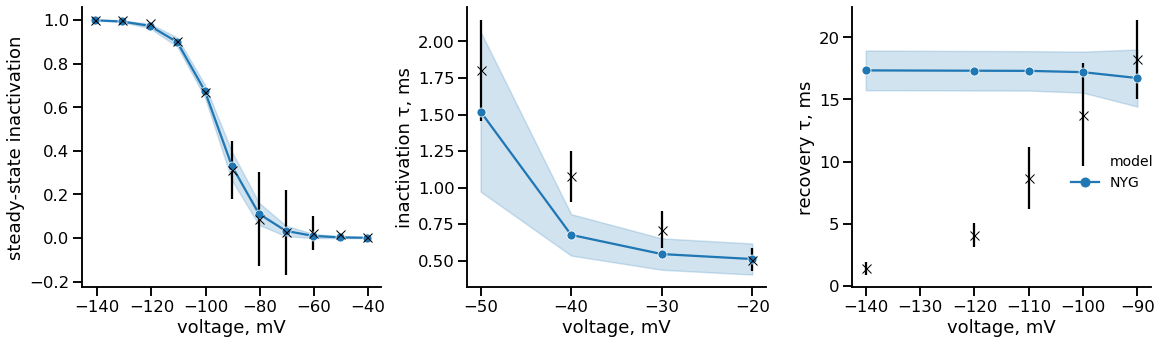

In [35]:
g = plot_sim_results(nyg_modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df_nyg[list(limits_nyg.keys())], w=w_nyg)

xlabel = "voltage, mV"
ylabels = ["steady-state inactivation", "inactivation τ, ms", "recovery τ, ms"]

for ax in g.axes[0]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes[0], ylabels):
    ax.set_ylabel(yl)
for ax in g.axes[0].flatten():
    ax.set_title('')
plt.tight_layout()

We can also plot the model discrepancy variance posterior distributions for each experiment. Here we see that virtually no variance is added to the first steady-state experiment, whereas a larger amount is added to the time constant experiments. This appears proportional to the deviation of the model from the experimental data and highlights where the model is deficient with respect to the data. 

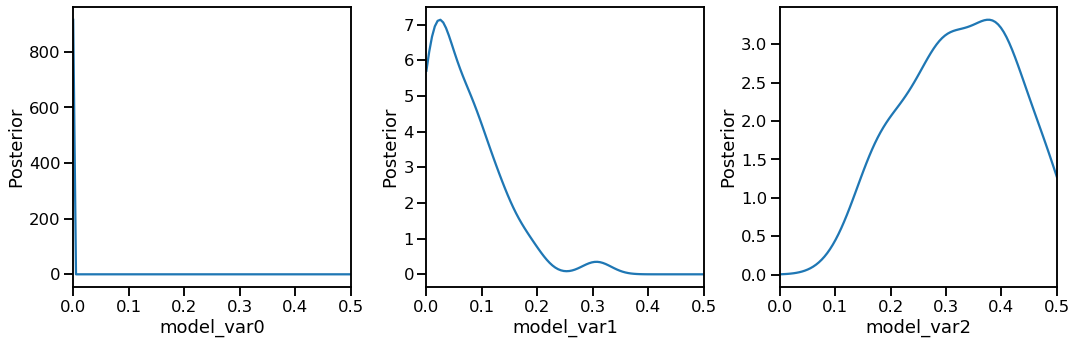

In [36]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, a in enumerate(ax):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_nyg, x=f"model_var{i}",
        xmin=0., xmax=0.5, numx=100, ax=a)
plt.tight_layout()

## Comparing to the standardised gate

We follow a similar set-up process and calibration for the standardised gate below.

In [62]:
# the standardised model has four parameters to be calibrated
# Note: prepending log_ has the effect of sampling in the log-space for this parameter
limits_sta = {'log_ina.p_5': (-7., 3.),
              'ina.p_6': (1e-7, 0.4),
              'log_ina.p_7': (-7., 3.),
              'ina.p_8': (1e-7, 0.4)}
prior_RV = {key: pyabc.RV("uniform", a, b - a)
            for key, (a,b) in limits_sta.items()}

In [38]:
prior_RV.update({'model_var0': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var1': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var2': pyabc.RV("uniform", 1e-7, 0.5)})
prior = pyabc.Distribution(**prior_RV)

In [39]:
observations, model, summary_statistics = setup(sta_modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast,
                                                err_pars=['model_var0','model_var1','model_var2'])

In [40]:
# Test it all works correctly with set-up functions
assert len(observations)==len(summary_statistics(model({})))
assert len(observations) == len(summary_statistics(model(prior.rvs())))

AssertionError: 

In [41]:
keys = list(observations.index)
keys = [str(k) for k in keys]

In [43]:
measure_var = list(observations.variance)
exp_mask = list(observations.exp_id)

In [44]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ina_model_discrepancy.db"))

In [45]:
theoretical_population_size(2, len(prior_RV))

128

In [46]:
acceptor = pyabc.StochasticAcceptor()
kernel = DiscrepancyKernel(keys=keys,
                           measure_var=measure_var,
                           eps_keys=['model_var0','model_var1','model_var2'],
                           exp_mask=exp_mask)
eps = pyabc.Temperature(initial_temperature=1000.,
                        schemes=[pyabc.DalyScheme(alpha=0.2, min_rate=0.001)])
n_particles = 200
population_size = pyabc.ConstantPopulationSize(n_particles)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
#sampler = pyabc.sampler.SingleCoreSampler() # for testing
transition = pyabc.LocalTransition()

In [47]:
abc = pyabc.ABCSMC(model, prior, kernel,
                   summary_statistics=summary_statistics,
                   eps=eps, 
                   acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)

In [48]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [19]:
history = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-11-29 21:13:12.182846, end_time=None)>


Uncomment to run the calibration (as before).

In [20]:
#history = abc.run(max_nr_populations=100)

INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 1000.0.
INFO:ABC:Acceptance rate: 200 / 15537 = 1.2872e-02.
INFO:ABC:t: 1, eps: 639.9999999999999.
INFO:ABC:Acceptance rate: 200 / 366 = 5.4645e-01.
INFO:ABC:t: 2, eps: 409.59999999999985.
INFO:ABC:Acceptance rate: 200 / 434 = 4.6083e-01.
INFO:ABC:t: 3, eps: 262.14399999999995.
INFO:ABC:Acceptance rate: 200 / 439 = 4.5558e-01.
INFO:ABC:t: 4, eps: 167.77215999999996.
INFO:ABC:Acceptance rate: 200 / 460 = 4.3478e-01.
INFO:ABC:t: 5, eps: 107.37418239999997.
INFO:ABC:Acceptance rate: 200 / 523 = 3.8241e-01.
INFO:ABC:t: 6, eps: 68.71947673599998.
INFO:ABC:Acceptance rate: 200 / 632 = 3.1646e-01.
INFO:ABC:t: 7, eps: 43.98046511103998.
INFO:ABC:Acceptance rate: 200 / 774 = 2.5840e-01.
INFO:ABC:t: 8, eps: 28.147497671065587.
INFO:ABC:Acceptance rate: 200 / 1123 = 1.7809e-01.
INFO:ABC:t: 9, eps: 18.014398509481975.
INFO:ABC:Acceptance rate: 200 / 1659 = 1.2055e-01.
INFO:ABC:t: 10, eps: 11.529215046068465.
INFO:ABC:Acceptance rate: 200 

In [64]:
history_sta = pyabc.History('sqlite:///results/standardised_ina_model_discrepancy.db')

In [65]:
df_sta, w_sta = history_sta.get_distribution(m=0)

In [66]:
df_sta.describe()

name,ina.p_6,ina.p_8,log_ina.p_5,log_ina.p_7,model_var0,model_var1,model_var2
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000
mean,0.063411,0.089386,1.101857,-5.222743,5.335698e-04,0.046758,0.020379
std,0.004390,0.014045,0.142876,0.617653,5.609705e-04,0.049511,0.021414
min,0.053017,0.058111,0.822865,-6.870672,3.789158e-07,0.000257,0.000070
25%,0.060378,0.080821,1.000437,-5.458718,1.340842e-04,0.012050,0.004391
50%,0.062876,0.086778,1.089507,-5.097051,3.361494e-04,0.029336,0.014328
75%,0.066001,0.093953,1.181513,-4.846260,7.892464e-04,0.073118,0.027779
max,0.074395,0.127516,1.628006,-3.786425,3.555428e-03,0.257585,0.130707


The standardised formulation is closer to the experimental data particularly in the time constant behaviour. This is a result of the differing form of this part of the gate equations which have a peaked shape.

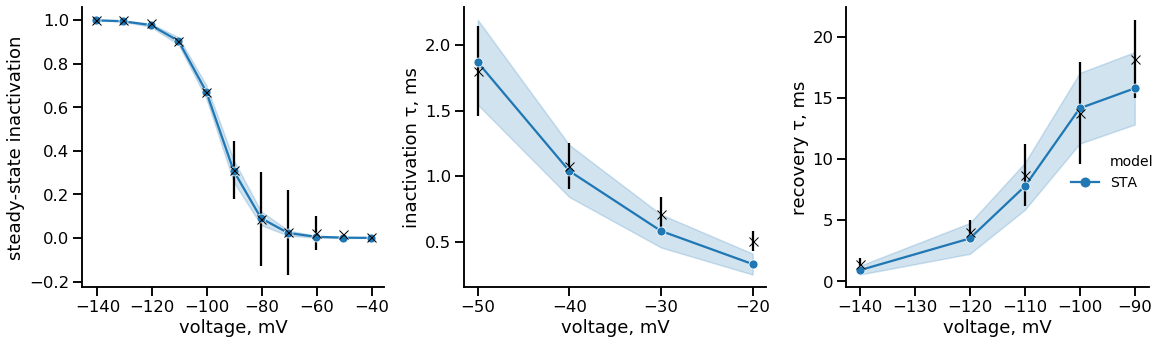

In [56]:
g = plot_sim_results(sta_modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df_sta[list(limits_sta.keys())], w=w_sta)

xlabel = "voltage, mV"
ylabels = ["steady-state inactivation", "inactivation τ, ms", "recovery τ, ms"]

for ax in g.axes[0]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes[0], ylabels):
    ax.set_ylabel(yl)
for ax in g.axes[0].flatten():
    ax.set_title('')
plt.tight_layout()

The lower discrepancy to experimental data is reflected in the calibration of the model discrepancy variances for each experiment. Particularly for experiment 2, we observe this is reduced from the Nygren model.

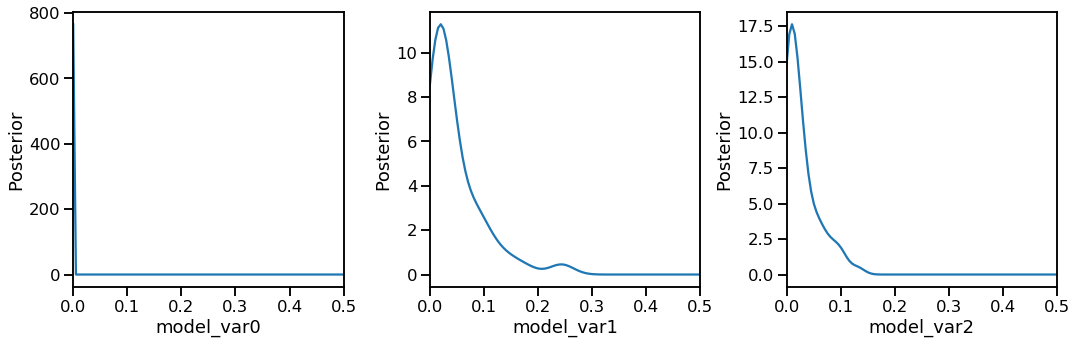

In [57]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, a in enumerate(ax):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x=f"model_var{i}",
        xmin=0., xmax=0.5, numx=100, ax=a)
plt.tight_layout()

## Direct comparisons between the models

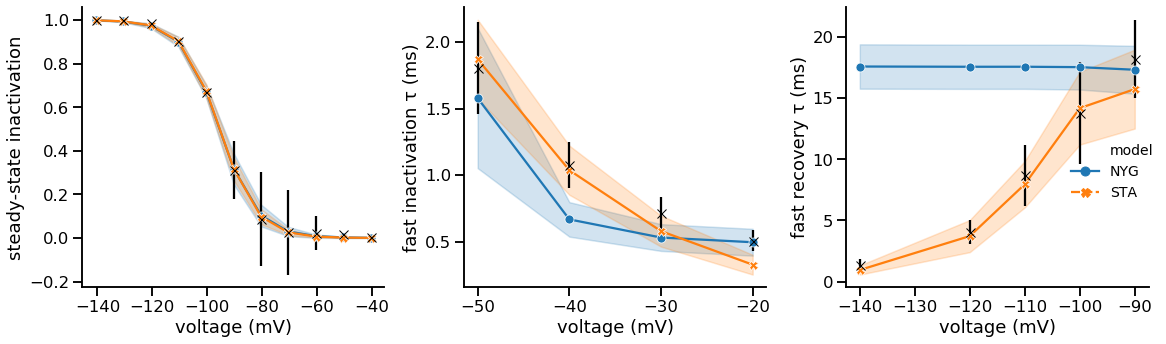

In [69]:
g = plot_sim_results([nyg_modelfile,
                      sta_modelfile],
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=[df_nyg[list(limits_nyg.keys())],
                         df_sta[list(limits_sta.keys())]],
                     w=[w_nyg,
                        w_sta])

ylabels = ["steady-state inactivation",
           "fast inactivation τ (ms)", 
           "fast recovery τ (ms)"]

for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

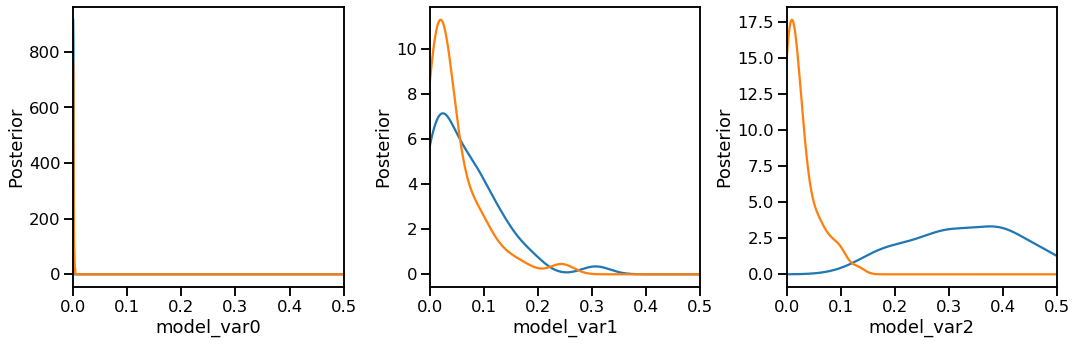

In [77]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, a in enumerate(ax):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_nyg, x=f"model_var{i}",
        xmin=0., xmax=0.5, numx=1000, ax=a)
    pyabc.visualization.plot_kde_1d_highlevel(
        history_sta, x=f"model_var{i}",
        xmin=0., xmax=0.5, numx=1000, ax=a)
plt.tight_layout()